In [ ]:
#######################
###  Global paths   ###
#######################
custom_module_path = f'/content/drive/MyDrive/MoA/utilites'
dataset_path = f'/content/drive/MyDrive/MoA/dataset'

#######################
### Library imports ###
#######################
# standard library
import os
import sys
import copy

#custom tooling
sys.path.append(custom_module_path)
import resnet
import preprocess

In [ ]:
import tensorflow as tf

# Configurations

length = 877  # Length of each Segment
model_name = 'ResNet18_2_output'  # DenseNet Models
model_width = 64  # Width of the Initial Layer, subsequent layers start from here
num_channel = 1  # Number of Input Channels in the Model
problem_type = 'Classification'  # Classification or Regression
output_nums = 206  # Number of Class for Classification Problems, always '1' for Regression Problems
  
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
  
Model = resnet.ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, pooling='avg',dropout_rate=0.3).ResNet_18_LSTM()
Model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 877, 1)]     0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 439, 64)      512         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 439, 64)     256         ['conv1d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 439, 64)      0           ['batch_normalization_17[0]

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

def split_data(X,y, size_test=0.1):
    X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=size_test, random_state=19)
    return X_tr,X_test,y_tr,y_test 

def preprocess_data(X,y):
    transformer = preprocess.Preprocessor() 
    transformer.fit(X)
    X = transformer.transform(X)
    y = y.drop(["sig_id"], axis = 1).values.astype("float32") 
    return pd.DataFrame(X),pd.DataFrame(y)

drugs = pd.read_csv(f'{dataset_path}/train_drug.csv')
train_drug = pd.read_csv(f'{dataset_path}/train_drug.csv')
X = pd.read_csv(f'{dataset_path}/train_features.csv')
y = pd.read_csv(f'{dataset_path}/train_targets_scored.csv')

X,y = preprocess_data(X,y)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_val, y_train, y_val = split_data(X_train,y_train,0.2)

In [ ]:
print(f'x_train: {X_train.shape}\nx_val: {X_val.shape}')
print(f'y_train: {y_train.shape}\ny_val: {y_val.shape}')

x_train: (17145, 877)
x_val: (4287, 877)
y_train: (17145, 206)
y_val: (4287, 206)


In [ ]:
X_train, X_val = np.array(X_train), np.array(X_val)
y_train, y_val = y_train.values.astype("float32"), y_val.values.astype("float32")

In [ ]:
history = Model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30, verbose=1)

Epoch 1/30
536/536 [==============================] - 40s 52ms/step - loss: 0.0675 - accuracy: 0.0053 - val_loss: 0.0525 - val_accuracy: 9.3305e-04
Epoch 2/30
536/536 [==============================] - 27s 50ms/step - loss: 0.0528 - accuracy: 0.0028 - val_loss: 0.0525 - val_accuracy: 6.9979e-04
Epoch 3/30
536/536 [==============================] - 28s 51ms/step - loss: 0.0528 - accuracy: 0.0036 - val_loss: 0.0525 - val_accuracy: 9.3305e-04
Epoch 4/30
536/536 [==============================] - 28s 53ms/step - loss: 0.0528 - accuracy: 0.0038 - val_loss: 0.0525 - val_accuracy: 0.0023
Epoch 5/30
536/536 [==============================] - 32s 60ms/step - loss: 0.0528 - accuracy: 0.0045 - val_loss: 0.0525 - val_accuracy: 0.0044
Epoch 6/30
536/536 [==============================] - 29s 54ms/step - loss: 0.0528 - accuracy: 0.0032 - val_loss: 0.0525 - val_accuracy: 0.0056
Epoch 7/30
536/536 [==============================] - 27s 50ms/step - loss: 0.0528 - accuracy: 0.0045 - val_loss: 0.0525 - v

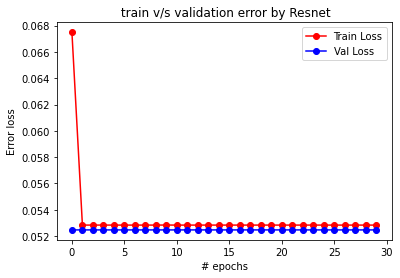

In [ ]:
import matplotlib.pyplot as plt

def plotErrors(train_error, val_error, name='by Resnet'):  
    plt.plot(train_error, color='red', marker='o', label='Train Loss')
    plt.plot(val_error, color='blue', marker='o', label='Val Loss')
    plt.title(f' train v/s validation error {name}')
    plt.xlabel('# epochs')
    plt.ylabel('Error loss') 
    plt.legend(loc="upper right")
    plt.show()

plotErrors(history.history['loss'],history.history['val_loss'])